In [1]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import torch
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from tqdm.keras import TqdmCallback

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
#loading---------------------------------------------------------------------------------------

df10 = pd.read_csv('/kaggle/input/jissen-marketing/gi_train_mm10.csv')
df11 = pd.read_csv('/kaggle/input/jissen-marketing/gi_train_mm11.csv')
df_test = pd.read_csv('/kaggle/input/jissen-marketing/gi_test.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
#使わない列の削除
drop_cols = ['store_id','store', 'project_category']
df10 = df10.drop(drop_cols,axis = 1)
df11 = df11.drop(drop_cols,axis = 1)
df_test = df_test.drop(drop_cols,axis = 1)

In [3]:
df10.shape, df11.shape,df_test.shape

((18897, 15), (4366, 15), (10254, 14))

In [4]:
df = pd.concat([df10, df11])
df = df[df["customer_id"].notna()]

In [5]:
#外れ値
df[df['customer_id']=='20201101-060103']
print(df[df['time_duration']>400])


         customer_id  event_day  area_id gender   age age_category  \
780  20201101-060103  2020/11/1      NaN  woman  60's       Senior   

     event_type  product_id product_name company  time_duration  num_touch  \
780           1         NaN          NaN     NaN          421.6        0.0   

          in_time      out_time  buy_flag  
780  14:40:06.600  14:47:08.200         0  


* event1:フレームイン　フレームアウト

* event2:エリアイン　エリアアウト

* event3:商品接触購入

# ここまでのメモ
* eventごとに分けることで、同じ数の欠損値を確認できる。もしモデルを分けるならば、dropしてよいカラムになる

* event3　のみがbuy flagとして0 or 1の値を持ち、それ以外のeventは全て0

* 2020/10/26~2020/11/1までの１週間のデータで、train testで同じcustomer idの人はいない。

* 一度フレームアウトすると違う人と認識されるので、各customer_idに対してevent_type1は１つだけ

* 提出は2209行のデータフレームで、購入確率とcustomer_id（被りなし）で構成される。つまり、ある人が１本でもよいので購入すれば、購入フラグが立つことになる

> (注意)不均衡データとなっている

# 商品を購入するためにはエリアまたは、フレームに入る必要がある。
# つまり、

In [6]:
# df_train 内で event_type が 3 の行の customer_id を抽出

def check_id(df_train):
    customer_ids_with_event_type_3 = df_train[df_train['event_type'] == 3]['customer_id'].unique()

    # 出力
    print(f'event_typeが3を持つユニークなcustomer_idの数は: {len(customer_ids_with_event_type_3)}')
    print(f'event_typeが3を持つユニークなcustomer_id: {customer_ids_with_event_type_3}')
check_id(df)
check_id(df_test)

event_typeが3を持つユニークなcustomer_idの数は: 3312
event_typeが3を持つユニークなcustomer_id: ['20201026-010001' '20201026-010003' '20201026-010005' ...
 '20201101-120047' '20201101-120049' '20201101-120052']
event_typeが3を持つユニークなcustomer_idの数は: 2209
event_typeが3を持つユニークなcustomer_id: ['20201026-010002' '20201026-010012' '20201026-010016' ...
 '20201101-120054' '20201101-120055' '20201101-120056']


In [7]:
# 各 customer_id についてユニークな product_name の数を計算
unique_product_counts = df.groupby('customer_id')['product_name'].nunique()

# ユニークな product_name の数が 2 以上の customer_id を抽出
customers_with_multiple_products = unique_product_counts[unique_product_counts >= 2].index

# 出力
print(f'2種類以上の飲み物を買っているユニークなcustomer_idの数は: {len(customers_with_multiple_products)}')
print(f'2種類以上の飲み物を買っているユニークなcustomer_id: {customers_with_multiple_products}')


2種類以上の飲み物を買っているユニークなcustomer_idの数は: 1019
2種類以上の飲み物を買っているユニークなcustomer_id: Index(['20201026-010008', '20201026-010010', '20201026-010017',
       '20201026-010020', '20201026-010035', '20201026-010041',
       '20201026-010048', '20201026-010058', '20201026-010077',
       '20201026-010085',
       ...
       '20201101-110084', '20201101-110093', '20201101-110110',
       '20201101-110116', '20201101-110123', '20201101-110134',
       '20201101-120016', '20201101-120017', '20201101-120041',
       '20201101-120052'],
      dtype='object', name='customer_id', length=1019)


* 複数商品がほぼ同じ時間に接触され、購入されているということは、、、複数本の購入をしたということ？

**比較する場合は値段を考慮する場合もある**

**商品の取り直しについてどのように考えるか、もっと冷えたやつを取りたいなど**

**商品名が同じものが複数行にまたがっている場合、取り直しをしたのか、複数個購入したのかがわからない**


In [8]:
import numpy as np

def process_dataframe(df,flag):#flagは訓練データかどうか
    # area_id と event_type のダミー変数を作成
    df = pd.get_dummies(df, columns=['area_id', 'event_type'], prefix=['area_id', 'event_type'])
    
    # time_duration をフレーム内にいた時間とエリア内にいた時間に分ける
    df['time_duration_frame'] = df['time_duration'].where(df['event_type_1']==1, 0)
    
    for i in range(1, 6):
        df[f'time_duration_area_{i}.0'] = df['time_duration'].where(df[f'area_id_{i}.0']==1, 0)
    
    # num_touch をカウントし、新しい特徴量として追加
    df['total_num_touches'] = df.groupby('customer_id')['num_touch'].transform('sum')
    
    
    # in_time と out_time をフレームおよびエリアの出入り時間として新たに作成
    df['in_time_in_frame'] = pd.to_datetime(df['in_time'].where(df['event_type_1']==1, np.nan)).astype(np.int64) // 10**9
    df['out_time_in_frame'] = pd.to_datetime(df['out_time'].where(df['event_type_1']==1, np.nan)).astype(np.int64) // 10**9
    df['in_time_in_area'] = pd.to_datetime(df['in_time'].where(df['event_type_2']==1, np.nan)).astype(np.int64) // 10**9
    df['out_time_in_area'] = pd.to_datetime(df['out_time'].where(df['event_type_2']==1, np.nan)).astype(np.int64) // 10**9
    
    

        # event_type_3が1の行のみを考慮
    touch_df = df[df['event_type_3'] == 1].copy()

    # in_time列を日時型に変換
    touch_df['in_time'] = pd.to_datetime(touch_df['in_time'])

    # Unixタイムスタンプ（秒）に変換
    touch_df['in_time'] = touch_df['in_time'].astype(np.int64) // 10**9

    # 各customer_idについての最初と最後の接触時間
    touch_df['first_touch_time'] = touch_df.groupby('customer_id')['in_time'].transform('min')
    touch_df['last_touch_time'] = touch_df.groupby('customer_id')['in_time'].transform('max')

    # 元のデータフレームにマージ
    df = pd.merge(df, touch_df[['customer_id', 'first_touch_time', 'last_touch_time']], on='customer_id', how='left')

    # 接触していない顧客についてはNaNとなるので、それを0に置換
    df[['first_touch_time', 'last_touch_time']] = df[['first_touch_time', 'last_touch_time']].fillna(0)

    # 最後にint型に変換
    df['first_touch_time'] = df['first_touch_time'].astype(int)
    df['last_touch_time'] = df['last_touch_time'].astype(int)




    # product_name と company の種類をカウント
    df['num_product_types'] = df.groupby('customer_id')['product_name'].transform('nunique')
    df['num_company_types'] = df.groupby('customer_id')['company'].transform('nunique')
    
    # areaに立ち寄っていない場合、'in_time_in_area'と'out_time_in_area'を0に設定
    df.loc[(df['area_id_1.0']==0) & (df['area_id_2.0']==0) & (df['area_id_3.0']==0) & (df['area_id_4.0']==0) & (df['area_id_5.0']==0), ['in_time_in_area', 'out_time_in_area']] = 0

    
    if flag ==1:
        # 同じcustomer_idを持つ行をまとめる
        aggregation = {
            'gender': 'first',  # 最初の値を保持
            'age': 'first',  # 最初の値を保持
            'age_category': 'first',  # 最初の値を保持
            'buy_flag': 'max',  # 1が1つでもあれば1
            'area_id_1.0': 'max',
            'area_id_2.0': 'max',
            'area_id_3.0': 'max',
            'area_id_4.0': 'max',
            'area_id_5.0': 'max',
            'event_type_1': 'max',
            'event_type_2': 'max',
            'event_type_3': 'max',
            'time_duration_frame': 'max',
            'time_duration_area_1.0': 'max',
            'time_duration_area_2.0': 'max',
            'time_duration_area_3.0': 'max',
            'time_duration_area_4.0': 'max',
            'time_duration_area_5.0': 'max',
            'total_num_touches': 'max',
            'in_time_in_frame': 'max',
            'out_time_in_frame': 'max',
            'in_time_in_area': 'max',
            'out_time_in_area': 'max',
            'num_product_types': 'max',
            'num_company_types': 'max',
            'first_touch_time':'min',
            'last_touch_time':'max'
        }
        df = df.groupby('customer_id').agg(aggregation).reset_index()
    else:
        aggregation = {
            'gender': 'first',  # 最初の値を保持
            'age': 'first',  # 最初の値を保持
            'age_category': 'first',  # 最初の値を保持
            #'buy_flag': 'max',  # 1が1つでもあれば1
            'area_id_1.0': 'max',
            'area_id_2.0': 'max',
            'area_id_3.0': 'max',
            'area_id_4.0': 'max',
            'area_id_5.0': 'max',
            'event_type_1': 'max',
            'event_type_2': 'max',
            'event_type_3': 'max',
            'time_duration_frame': 'max',
            'time_duration_area_1.0': 'max',
            'time_duration_area_2.0': 'max',
            'time_duration_area_3.0': 'max',
            'time_duration_area_4.0': 'max',
            'time_duration_area_5.0': 'max',
            'total_num_touches': 'max',
            'in_time_in_frame': 'max',
            'out_time_in_frame': 'max',
            'in_time_in_area': 'max',
            'out_time_in_area': 'max',
            'num_product_types': 'max',
            'num_company_types': 'max',
            'first_touch_time':'min',
            'last_touch_time':'max'
        }
        df = df.groupby('customer_id').agg(aggregation).reset_index()

    
    for i in ['area_id_1.0', 'area_id_2.0', 'area_id_3.0', 'area_id_4.0','area_id_5.0', 'event_type_1', 'event_type_2', 'event_type_3']:
        df[i] = df[i].astype(int)
    
    df = df.reset_index(drop=True)
    
    return df

train = process_dataframe(df,1)
test = process_dataframe(df_test,0)

def fe(df): 
    # 商品に最初に触るまでの時間を計算
    df['first_touch_from_frame'] = df['first_touch_time'] - df['in_time_in_frame']
    #df['first_touch_from_area'] = df['first_touch_time'] - df['in_time_in_area']
    
    # 商品に一度も触らなかった行の計算結果をNaNに置き換え
    df.loc[df['first_touch_time'] == 0, ['first_touch_from_frame']] = np.nan #,'first_touch_from_area'
    
    return df

t = fe(train)

In [9]:
test_id = test['customer_id']
drop_cols = ['in_time_in_frame','out_time_in_frame','in_time_in_area','out_time_in_area','first_touch_time','last_touch_time','customer_id']
train = train.drop(drop_cols,axis=1)
test = test.drop(drop_cols,axis=1)
X = train.drop('buy_flag',axis=1)
y = train['buy_flag']

In [10]:
X.shape,test.shape

((9116, 20), (2209, 20))

In [11]:
import pandas as pd

def convert_to_dummies(df, columns=['gender', 'age', 'age_category']):
    
    # Create dummy variables for specified columns
    dummies = pd.get_dummies(df[columns], drop_first=True)
    
    # Drop the original columns
    df = df.drop(columns, axis=1)
    
    # Concatenate the dummy columns to the DataFrame
    df = pd.concat([df, dummies], axis=1)
    
    return df

X = convert_to_dummies(X)
test = convert_to_dummies(test)

In [12]:
X.shape,test.shape

((9116, 29), (2209, 29))

In [13]:
c = ['event_type_1']
X = X.drop(c,axis = 1)
test = test.drop(c,axis = 1)

# モデル構築

# lgb そのまま

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.557851
[20]	valid_0's binary_logloss: 0.493929
[30]	valid_0's binary_logloss: 0.441009
[40]	valid_0's binary_logloss: 0.39653
[50]	valid_0's binary_logloss: 0.35869
[60]	valid_0's binary_logloss: 0.326186
[70]	valid_0's binary_logloss: 0.298201
[80]	valid_0's binary_logloss: 0.273961
[90]	valid_0's binary_logloss: 0.252803
[100]	valid_0's binary_logloss: 0.234272
[110]	valid_0's binary_logloss: 0.218031
[120]	valid_0's binary_logloss: 0.203723
[130]	valid_0's binary_logloss: 0.191189
[140]	valid_0's binary_logloss: 0.180247
[150]	valid_0's binary_logloss: 0.170609
[160]	valid_0's binary_logloss: 0.162021
[170]	valid_0's binary_logloss: 0.154415
[180]	valid_0's binary_logloss: 0.147684
[190]	valid_0's binary_logloss: 0.141697
[200]	valid_0's binary_logloss: 0.136442
[210]	valid_0's binary_logloss: 0.131745
[220]	valid_0's binary_logloss: 0.127593
[230]	valid_0's binary_logloss: 0.123906
[240]	v

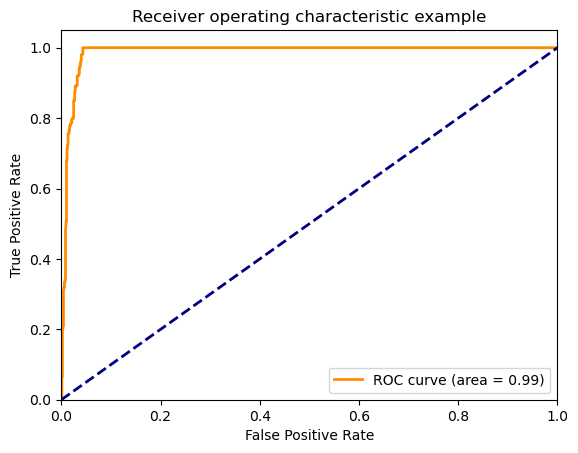

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.557786
[20]	valid_0's binary_logloss: 0.493869
[30]	valid_0's binary_logloss: 0.441129
[40]	valid_0's binary_logloss: 0.396852
[50]	valid_0's binary_logloss: 0.359364
[60]	valid_0's binary_logloss: 0.327304
[70]	valid_0's binary_logloss: 0.299716
[80]	valid_0's binary_logloss: 0.275881
[90]	valid_0's binary_logloss: 0.25515
[100]	valid_0's binary_logloss: 0.237052
[110]	valid_0's binary_logloss: 0.221215
[120]	valid_0's binary_logloss: 0.207335
[130]	valid_0's binary_logloss: 0.195167
[140]	valid_0's binary_logloss: 0.184456
[150]	valid_0's binary_logloss: 0.174998
[160]	valid_0's binary_logloss: 0.166695
[170]	valid_0's binary_logloss: 0.159251
[180]	valid_0's binary_logloss: 0.152706
[190]	valid_0's binary_logloss: 0.146934
[200]	valid_0's binary_logloss: 0.141892
[210]	valid_0's binary_logloss: 0.137457
[220]	valid_0's binary_logloss: 0.133597
[230]	valid_0's binary_logloss: 0.130208
[240]	

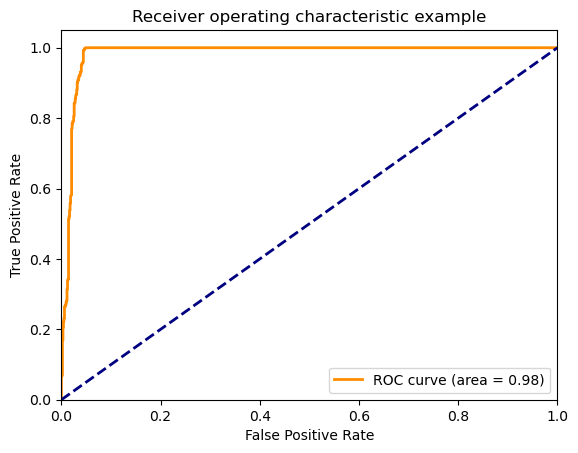

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.55837
[20]	valid_0's binary_logloss: 0.495391
[30]	valid_0's binary_logloss: 0.443505
[40]	valid_0's binary_logloss: 0.400091
[50]	valid_0's binary_logloss: 0.363207
[60]	valid_0's binary_logloss: 0.33181
[70]	valid_0's binary_logloss: 0.304796
[80]	valid_0's binary_logloss: 0.281507
[90]	valid_0's binary_logloss: 0.261412
[100]	valid_0's binary_logloss: 0.243966
[110]	valid_0's binary_logloss: 0.228818
[120]	valid_0's binary_logloss: 0.215691
[130]	valid_0's binary_logloss: 0.204121
[140]	valid_0's binary_logloss: 0.19403
[150]	valid_0's binary_logloss: 0.185247
[160]	valid_0's binary_logloss: 0.177557
[170]	valid_0's binary_logloss: 0.170686
[180]	valid_0's binary_logloss: 0.164662
[190]	valid_0's binary_logloss: 0.159391
[200]	valid_0's binary_logloss: 0.154787
[210]	valid_0's binary_logloss: 0.150725
[220]	valid_0's binary_logloss: 0.147155
[230]	valid_0's binary_logloss: 0.144031
[240]	va

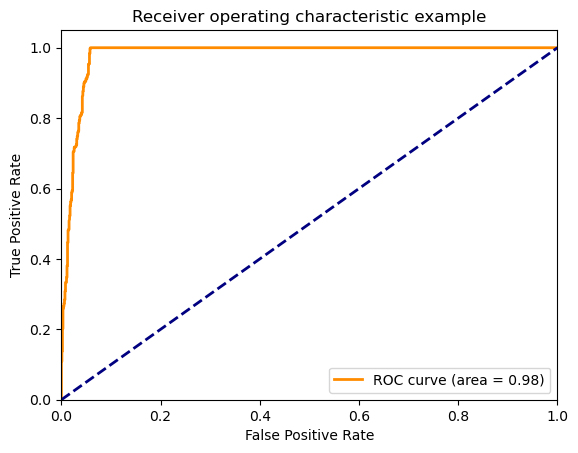

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.557031
[20]	valid_0's binary_logloss: 0.49236
[30]	valid_0's binary_logloss: 0.438819
[40]	valid_0's binary_logloss: 0.393667
[50]	valid_0's binary_logloss: 0.355182
[60]	valid_0's binary_logloss: 0.322121
[70]	valid_0's binary_logloss: 0.293581
[80]	valid_0's binary_logloss: 0.268787
[90]	valid_0's binary_logloss: 0.247168
[100]	valid_0's binary_logloss: 0.228271
[110]	valid_0's binary_logloss: 0.211687
[120]	valid_0's binary_logloss: 0.19705
[130]	valid_0's binary_logloss: 0.184119
[140]	valid_0's binary_logloss: 0.172745
[150]	valid_0's binary_logloss: 0.162759
[160]	valid_0's binary_logloss: 0.153898
[170]	valid_0's binary_logloss: 0.146037
[180]	valid_0's binary_logloss: 0.139093
[190]	valid_0's binary_logloss: 0.132957
[200]	valid_0's binary_logloss: 0.127546
[210]	valid_0's binary_logloss: 0.122685
[220]	valid_0's binary_logloss: 0.118393
[230]	valid_0's binary_logloss: 0.114573
[240]	v

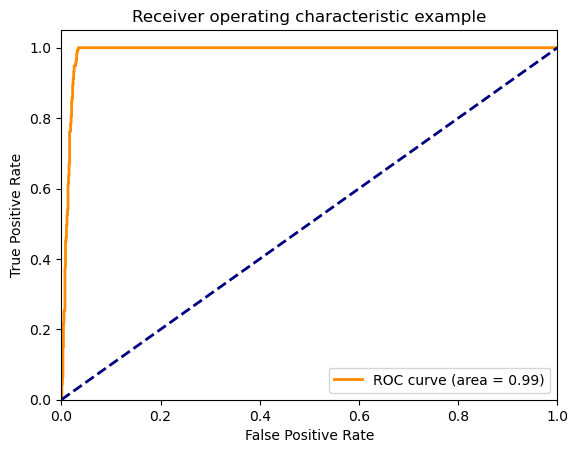

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.558247
[20]	valid_0's binary_logloss: 0.494402
[30]	valid_0's binary_logloss: 0.441494
[40]	valid_0's binary_logloss: 0.397013
[50]	valid_0's binary_logloss: 0.359181
[60]	valid_0's binary_logloss: 0.326776
[70]	valid_0's binary_logloss: 0.298845
[80]	valid_0's binary_logloss: 0.274603
[90]	valid_0's binary_logloss: 0.253515
[100]	valid_0's binary_logloss: 0.235077
[110]	valid_0's binary_logloss: 0.218908
[120]	valid_0's binary_logloss: 0.204726
[130]	valid_0's binary_logloss: 0.192223
[140]	valid_0's binary_logloss: 0.181207
[150]	valid_0's binary_logloss: 0.171477
[160]	valid_0's binary_logloss: 0.16289
[170]	valid_0's binary_logloss: 0.155249
[180]	valid_0's binary_logloss: 0.148523
[190]	valid_0's binary_logloss: 0.142571
[200]	valid_0's binary_logloss: 0.137295
[210]	valid_0's binary_logloss: 0.132594
[220]	valid_0's binary_logloss: 0.128363
[230]	valid_0's binary_logloss: 0.124581
[240]	

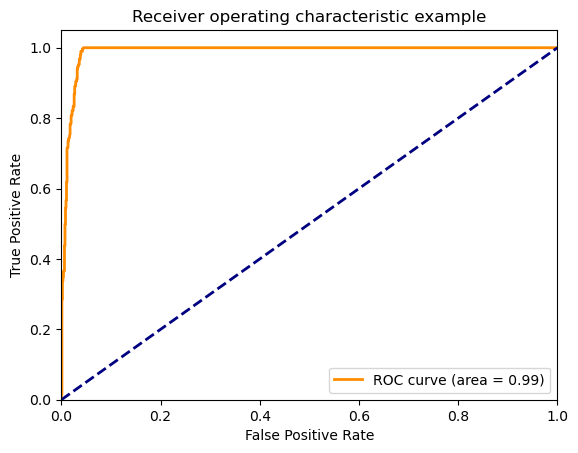

---------------Cross validation AUC:  0.9855619374896787
Training until validation scores don't improve for 20 rounds
[500]	valid_0's binary_logloss: 0.106773
Early stopping, best iteration is:
[631]	valid_0's binary_logloss: 0.105992


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold


# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルの初期化
model = LGBMClassifier(objective='binary',max_depth=5,n_estimators=1000,learning_rate=0.01, random_state=42)

# 5分割交差検証
kfold = StratifiedKFold(n_splits=5)
auc_scores = []

for train_index, val_index in kfold.split(X_train, y_train):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

    model.fit(X_train_kf, y_train_kf, eval_set=[(X_val_kf, y_val_kf)], callbacks=[early_stopping(10), log_evaluation(10)])
    
    y_pred_val = model.predict_proba(X_val_kf)[:, 1]
    auc_score = roc_auc_score(y_val_kf, y_pred_val)
    auc_scores.append(auc_score)
    
    
    #accuracyなど-----------------------------------------------------------------------------------------------------------------------------------------
    y_pred_binary = (y_pred_val > 0.5).astype(int)  # クラス分類の予測
    
    auc_score = roc_auc_score(y_val_kf, y_pred_val)
    accuracy = accuracy_score(y_val_kf, y_pred_binary)
    recall = recall_score(y_val_kf, y_pred_binary)
    precision = precision_score(y_val_kf, y_pred_binary)
    f1 = f1_score(y_val_kf, y_pred_binary)
    
    print("AUC: ", auc_score)
    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("F1 Score: ", f1)
    
    # ROC曲線とAUCスコアの計算----------------------------------------------------------------------------------------------------------------------------------------
    fpr, tpr, _ = roc_curve(y_val_kf, y_pred_val)
    roc_auc = auc(fpr, tpr)
    
    # ROC曲線の描画
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

print("---------------Cross validation AUC: ", np.mean(auc_scores))

# 最終モデルの訓練
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[early_stopping(20), log_evaluation(500)])

# テストデータに対する予測
test_proba = model.predict_proba(test)[:, 1]

# 提出ファイルの作成
submission = pd.DataFrame({'customer_id': test_id, 'buy_proba': test_proba})
submission.to_csv('submission_lgb.csv', index=False)


# lgb オーバーサンプリング

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.252155
[200]	valid_0's binary_logloss: 0.13853
[300]	valid_0's binary_logloss: 0.103845
[400]	valid_0's binary_logloss: 0.093143
[500]	valid_0's binary_logloss: 0.0900392
[600]	valid_0's binary_logloss: 0.0889863
[700]	valid_0's binary_logloss: 0.0887131
[800]	valid_0's binary_logloss: 0.0889196
Early stopping, best iteration is:
[751]	valid_0's binary_logloss: 0.0885792
AUC:  0.9874426323900489
Accuracy:  0.9742798353909465
Recall:  0.9938271604938271
Precision:  0.9564356435643564
F1 Score:  0.9747729566094854
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.249803
[200]	valid_0's binary_logloss: 0.135155
[300]	valid_0's binary_logloss: 0.0988654
[400]	valid_0's binary_logloss: 0.0867601
[500]	valid_0's binary_logloss: 0.082407
[600]	valid_0's binary_logloss: 0.080589
[700]	valid_0's binary_logloss: 0.079732
[800]	valid_0's binary_logloss: 0.079

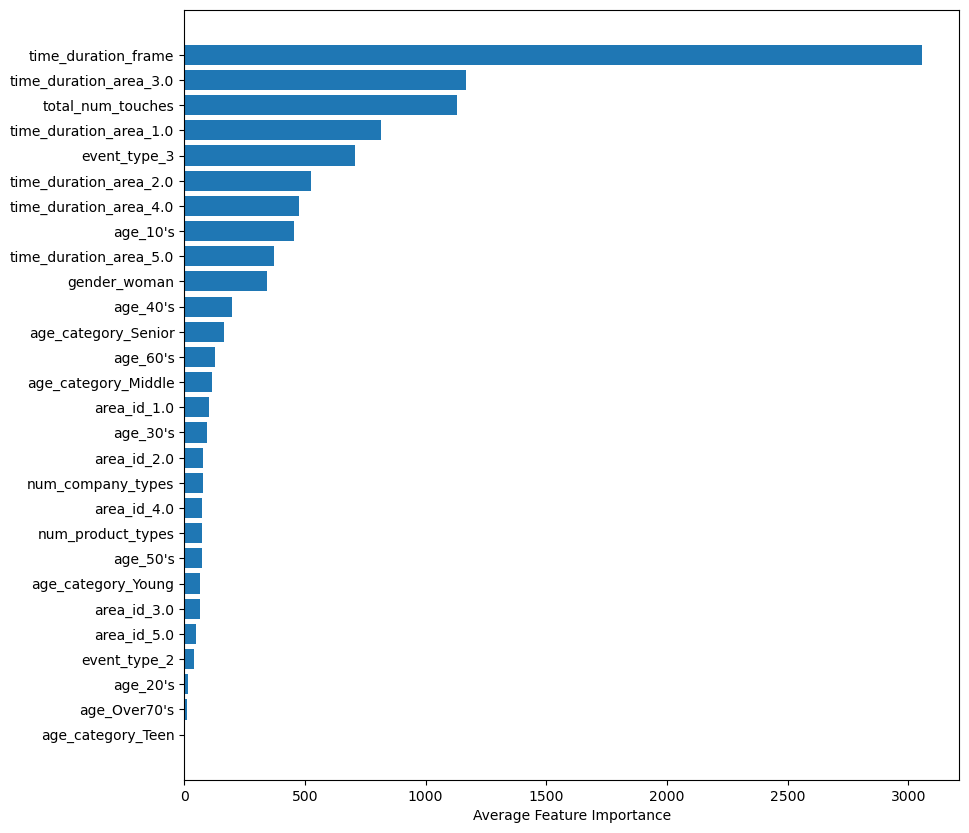

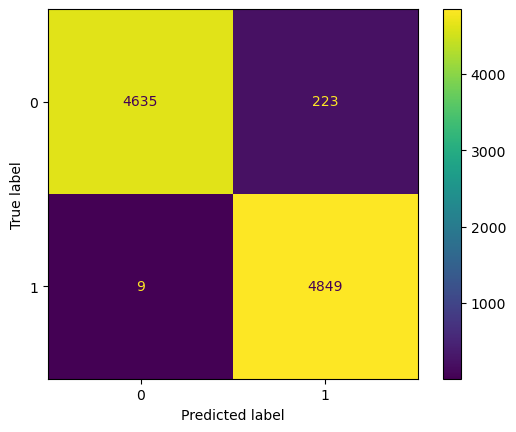

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score,confusion_matrix, ConfusionMatrixDisplay


# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTEを使用してオーバーサンプリング
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# モデルの初期化
model = LGBMClassifier(objective='binary',
          max_depth=5,
          #reg_alpha=0.1,         # L1正則化を増加
          #reg_lambda=0.1,
          #num_leaves=10,
          n_estimators=1000,
          learning_rate=0.01,
          random_state=42)

# 5分割交差検証
kfold = StratifiedKFold(n_splits=10)
auc_scores = []
test_probas = []
feature_importances = []
true_labels = []  # 実際のラベルを格納するためのリスト
pred_labels = []  # 予測ラベルを格納するためのリスト


for train_index, val_index in kfold.split(X_resampled, y_resampled):
    X_train_kf, X_val_kf = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train_kf, y_val_kf = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
    
    model.fit(X_train_kf, y_train_kf, eval_set=[(X_val_kf, y_val_kf)], callbacks=[early_stopping(50), log_evaluation(100)])
    
    y_pred_val = model.predict_proba(X_val_kf)[:, 1]
    auc_score = roc_auc_score(y_val_kf, y_pred_val)
    auc_scores.append(auc_score)
    
    
    # このfoldでのモデルを使って、テストデータの予測確率を計算
    fold_test_proba = model.predict_proba(test)[:, 1]
    test_probas.append(fold_test_proba)
    
    #accuracyなど-----------------------------------------------------------------------------------------------------------------------------------------
    y_pred_binary = (y_pred_val > 0.5).astype(int)  # クラス分類の予測
    
    auc_score = roc_auc_score(y_val_kf, y_pred_val)
    accuracy = accuracy_score(y_val_kf, y_pred_binary)
    recall = recall_score(y_val_kf, y_pred_binary)
    precision = precision_score(y_val_kf, y_pred_binary)
    f1 = f1_score(y_val_kf, y_pred_binary)
    
    auc_scores.append(auc_score)
    
    print("AUC: ", auc_score)
    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("F1 Score: ", f1)
    
    #混同行列の取得
    true_labels.extend(y_val_kf.tolist())
    pred_labels.extend(y_pred_binary.tolist())
    
    # このfoldでのモデルの特徴量の重要度を取得
    fold_importance = model.feature_importances_
    feature_importances.append(fold_importance)
    
    

print("CV AUC: ", np.mean(auc_scores))
# 各foldの特徴量の重要度の平均を計算
avg_importance = np.mean(feature_importances, axis=0)

# 平均の特徴量の重要度をプロット
plt.figure(figsize=(10, 10))
sorted_idx = avg_importance.argsort()
plt.barh(X.columns[sorted_idx], avg_importance[sorted_idx])
plt.xlabel("Average Feature Importance")
plt.show()

# 混同行列を計算
cm = confusion_matrix(true_labels, pred_labels)

# 混同行列を表示
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

avg_test_proba = np.mean(test_probas, axis=0)    

# 平均の予測確率を使用して提出ファイルを作成
submission_lgb_over = pd.DataFrame({'customer_id': test_id, 'buy_proba': avg_test_proba})
submission_lgb_over.to_csv('submission_lgb_over.csv', index=False)

* 5Cross validation AUC:  0.9886791475647684

* 10Cross validation AUC:  0.9889654843705726
